Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [289]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
#!ls /content/gdrive/MyDrive/Project/CNN/Train

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Project/CNN/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Project/CNN/Test')

In [307]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2275
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [309]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [311]:
from re import S
## Train Data 
## seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size 180*180, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6775 files belonging to 9 classes.
Using 5420 files for training.


In [313]:
## WValidation dataset
## used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized images to the size 180*180, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6775 files belonging to 9 classes.
Using 1355 files for validation.


In [11]:
# List of all the classes of skin cancer,stored them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize one instance of all the nine classes present in the dataset

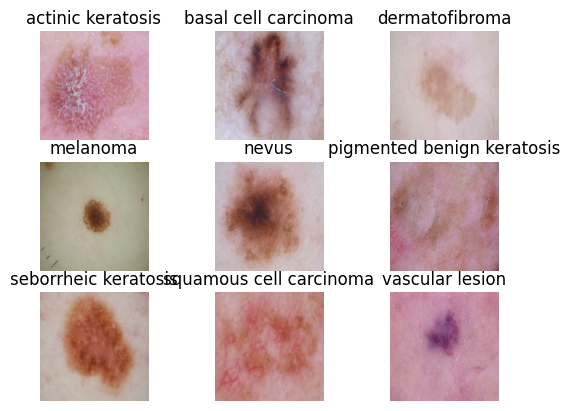

In [9]:
import matplotlib.pyplot as plt

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####  Use d```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. Standardized values to be in the `[0, 1]`

In [47]:
input_shape = (180,180,3)
num_classes = len(class_names)
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255,input_shape=input_shape))
model.add(tf.keras.layers.Resizing(180,180))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu')) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected

model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_2 (Resizing)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 121104)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       7,750,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,756,825 (29.59 MB)

 Trainable params: 7,756,825 (29.59 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [48]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



### Train the model

In [49]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2801 - loss: 2.1923 - val_accuracy: 0.3929 - val_loss: 1.5566
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4630 - loss: 1.4522 - val_accuracy: 0.5583 - val_loss: 1.2143
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6087 - loss: 1.0803 - val_accuracy: 0.5902 - val_loss: 1.1274
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7133 - loss: 0.8220 - val_accuracy: 0.6820 - val_loss: 0.8986
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7811 - loss: 0.6470 - val_accuracy: 0.7299 - val_loss: 0.8380
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8495 - loss: 0.4647 - val_accuracy: 0.7601 - val_loss: 0.7800
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8865 - loss: 0.3689 - val_accuracy: 0.7725 - val_loss: 0.7490
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9259 - loss: 0.2437 - val_a

### Visualizing training results

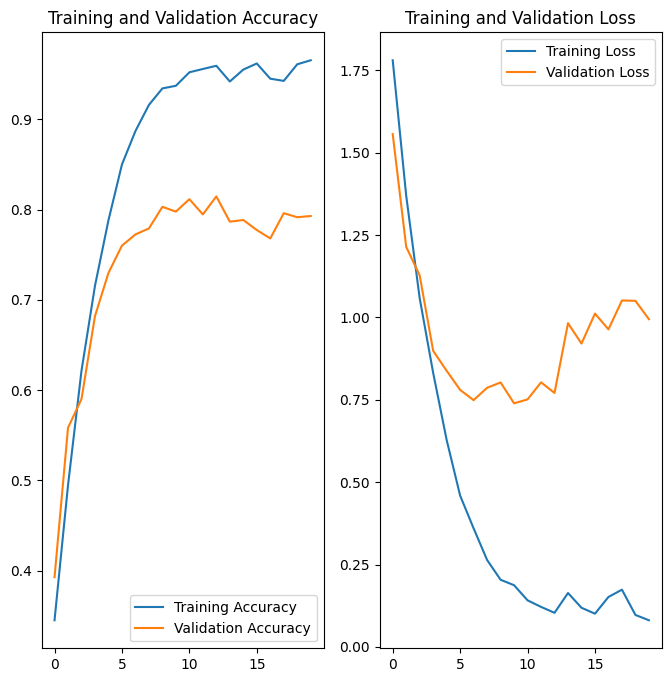

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### #### Training Accuracy is high 97% but validation accuracy is low at 79%, this indicates that there has been overfitting

Training loss reduces after each epoch where as validation loss remains consistent 6 epoch

### Write your findings here

In [15]:
# Choosing vertical and Horizontal flipping augmentation strategy
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

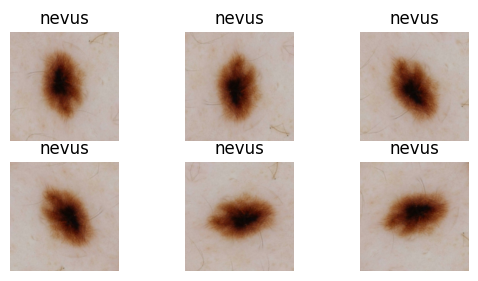

In [43]:
for image, label in train_ds.take(1,0):
  for i in range(6):
    augmented_image = data_augmentation(image[0])
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image.numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')


### Todo:
### Create the model, compile and train the model


In [51]:
input_shape = (180,180,3)
num_classes = len(class_names)
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255,input_shape=input_shape))
model.add(tf.keras.layers.Resizing(180,180))
model.add(layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4)),
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu')) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_3 (Resizing)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 242208)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      31,002,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,014,057 (118.31 MB)

 Trainable params: 31,014,057 (118.31 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [52]:
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

### Training the model

In [53]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.1990 - loss: 3.8816 - val_accuracy: 0.3517 - val_loss: 1.6917
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.3433 - loss: 1.6893 - val_accuracy: 0.3561 - val_loss: 1.7154
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.3733 - loss: 1.5767 - val_accuracy: 0.4310 - val_loss: 1.4611
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4356 - loss: 1.4471 - val_accuracy: 0.4328 - val_loss: 1.4200
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4634 - loss: 1.3585 - val_accuracy: 0.4656 - val_loss: 1.3575
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5199 - loss: 1.2309 - val_accuracy: 0.5397 - val_loss: 1.2166
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5640 - loss: 1.1504 - val_accuracy: 0.5463 - val_loss: 1.2079
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5878 - loss: 1.0962 - val_

### Visualizing the results

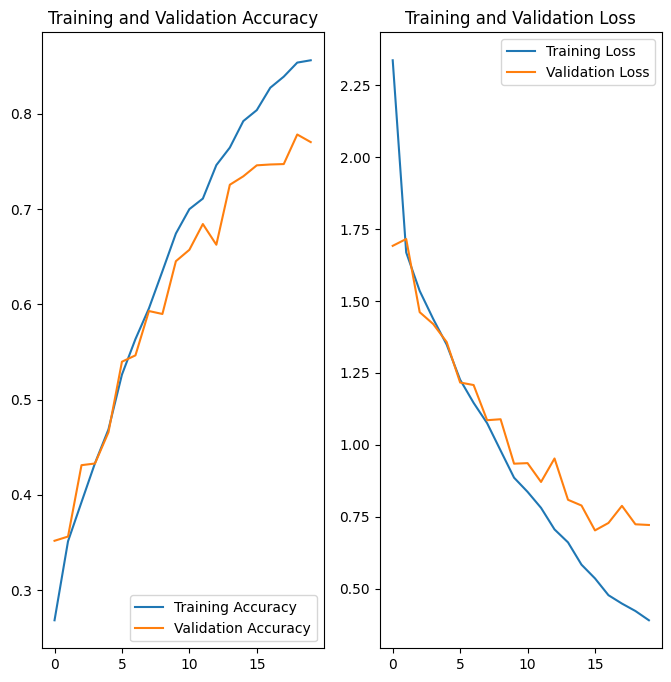

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Both train and validation accurcy has decreased but validation loss has decreased consistently and is on-par with training loss

#### **Todo:** Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [56]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,448
1,nevus,357
2,seborrheic keratosis,77
3,squamous cell carcinoma,181
4,actinic keratosis,114
5,pigmented benign keratosis,488
6,basal cell carcinoma,376
7,vascular lesion,139
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

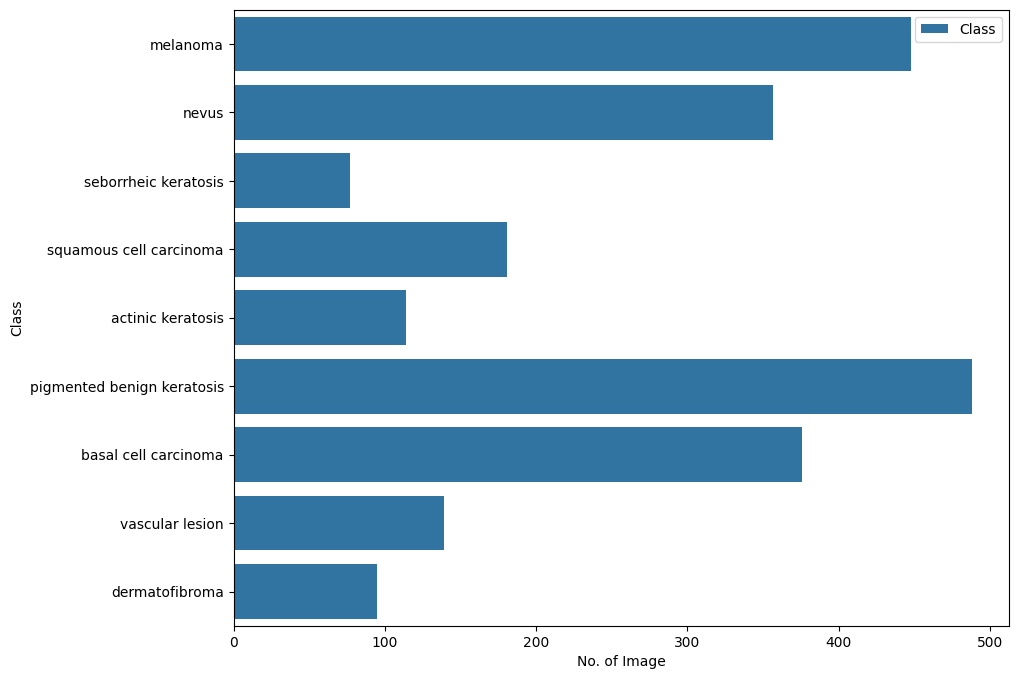

In [57]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### - seborrheic keratosis has least number of samples
#### - pigmented benign keratosis has larger number of samples


#### Rectifying class imabalance by creating images for each of the class through Augmentor

In [58]:
!pip install Augmentor

In [59]:
!ls /content/gdrive/MyDrive/Project/CNN/Train

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [60]:
path_to_training_dataset="/content/gdrive/MyDrive/Project/CNN/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3776D80ED0>: 100%|██████████| 500/500 [00:24<00:00, 20.45 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A39B561B750>: 100%|██████████| 500/500 [00:18<00:00, 26.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3776C10290>: 100%|██████████| 500/500 [00:20<00:00, 24.21 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=944x1127 at 0x7A3776CAA690>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7A3776CDC050>: 100%|██████████| 500/500 [01:16<00:00,  6.53 Samples/s]


Initialised with 488 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3891918FD0>: 100%|██████████| 500/500 [00:23<00:00, 21.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A3776C990D0>: 100%|██████████| 500/500 [00:43<00:00, 11.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3776CCB710>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Project/CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3776CDC050>: 100%|██████████| 500/500 [00:18<00:00, 26.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [61]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [62]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0000170.jpg_9ca2495e-3fdd-4760-a7a8-6c5876c70cfb.jpg',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0001157.jpg_a0b5b3b7-475f-4cb3-9e38-0478abb440e6.jpg',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010393.jpg_14fb66ad-b2c3-4976-8d8a-1d38015798f2.jpg',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010777.jpg_0a20f257-f7e2-4788-921e-ebee427ecdee.jpg',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010189.jpg_9a457197-1475-4cc5-9251-a3e59831361a.jpg',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010609.jpg_757dd16b-10ed-4630-986e-e117e9856677.jpg',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010796.jpg_db3865e4-76db-4167-803f-c3123148e1b7.jpg',
 '/content/gdrive/MyDrive/Project/

In [63]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [64]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
dataframe_dict_new

{'/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0000170.jpg_9c9e2460-b0b3-4f2c-b76a-c1fc14224be1.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0000390.jpg_f33aa4eb-4148-488c-bab0-7a268d5e1e5f.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010023.jpg_5d852a30-fe74-45c1-8e50-98c5e6dcc728.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010770.jpg_3935c782-a3fb-4d9c-8a01-55bef517736a.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010094.jpg_5d2ac573-b166-4ce7-949d-a67e69b3a3e7.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0010485.jpg_2b88e528-89c1-4067-9790-3f057461f857.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Project/CNN/Train/melanoma/output/melanoma_original_ISIC_0000145.jpg_ee7cc

In [65]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [66]:
df2['Label'].value_counts()

,count
Label,
melanoma,500
nevus,500
seborrheic keratosis,500
squamous cell carcinoma,500
actinic keratosis,500
pigmented benign keratosis,500
basal cell carcinoma,500
vascular lesion,500
dermatofibroma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [4]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Created a training dataset

In [319]:
data_dir_train="/content/gdrive/MyDrive/Project/CNN/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6775 files belonging to 9 classes.
Using 5420 files for training.


#### **Todo:** Created a validation dataset

In [321]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6775 files belonging to 9 classes.
Using 1355 files for validation.


#### **Todo:** model using batch normalisaton

In [15]:
input_shape = (180,180,3)
num_classes = len(class_names)
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255,input_shape=input_shape))
model.add(tf.keras.layers.Resizing(180,180))
model.add(layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4)),
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu')) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected
model.add(BatchNormalization())
model.add(Dense(128, activation='relu')) # fully connected
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_2 (Resizing)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 242208)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │      15,501,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,521,257 (59.21 MB)

 Trainable params: 15,521,129 (59.21 MB)

 Non-trainable params: 128 (512.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [17]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 52s 267ms/step - accuracy: 0.2981 - loss: 1.8992 - val_accuracy: 0.2517 - val_loss: 2.8584
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 229ms/step - accuracy: 0.4758 - loss: 1.4159 - val_accuracy: 0.2576 - val_loss: 2.2424
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.5161 - loss: 1.3114 - val_accuracy: 0.3631 - val_loss: 1.8356
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 43s 241ms/step - accuracy: 0.5152 - loss: 1.2804 - val_accuracy: 0.3055 - val_loss: 1.8636
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.5180 - loss: 1.2658 - val_accuracy: 0.2782 - val_loss: 2.9398
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 39s 229ms/step - accuracy: 0.5499 - loss: 1.1995 - val_accuracy: 0.4362 - val_loss: 1.5764
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - accuracy: 0.5935 - loss: 1.1101 - val_accuracy: 0.3033 - val_loss: 3.0390
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.5927 - loss: 1

#### **Todo:**  Visualize the model results

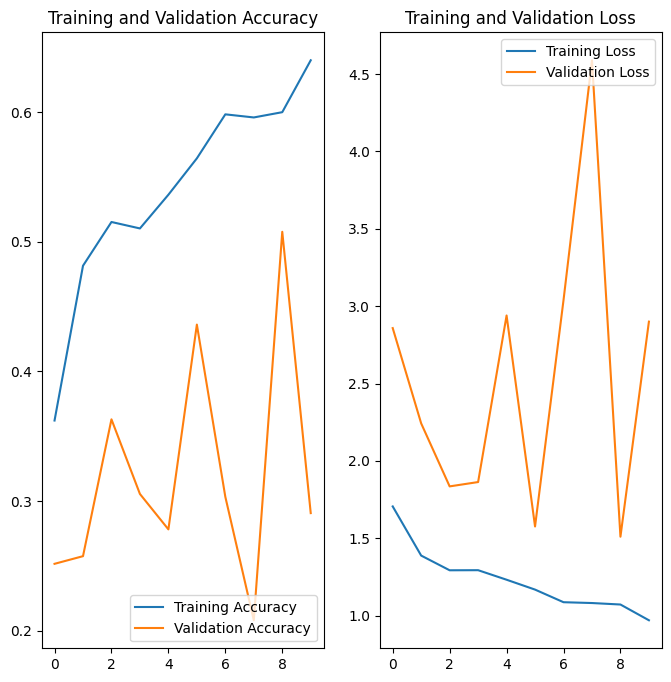

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training accuracy is high and validation accuracy is low validation loss is high and hence reverting to original model without Batch normalisation

In [331]:
input_shape = (180,180,3)
num_classes = len(class_names)
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255,input_shape=input_shape))
model.add(tf.keras.layers.Resizing(180,180))
model.add(layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4)),
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu')) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected
model.add(Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_28 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_25 (Resizing)          │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 87, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 242208)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │    15,501,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,512,105 (59.17 MB)

 Trainable params: 15,512,105 (59.17 MB)

 Non-trainable params: 0 (0.00 B)

In [333]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [335]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 46s 266ms/step - accuracy: 0.1973 - loss: 2.2969 - val_accuracy: 0.3328 - val_loss: 1.9160
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.3521 - loss: 1.7646 - val_accuracy: 0.3365 - val_loss: 1.6359
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.4179 - loss: 1.5799 - val_accuracy: 0.4111 - val_loss: 1.5228
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.4494 - loss: 1.4772 - val_accuracy: 0.5077 - val_loss: 1.2991
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.5007 - loss: 1.3493 - val_accuracy: 0.5387 - val_loss: 1.2618
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.5074 - loss: 1.3467 - val_accuracy: 0.5240 - val_loss: 1.2528
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.5732 - loss: 1.1801 - val_accuracy: 0.5904 - val_loss: 1.1526
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.5872 - loss: 1

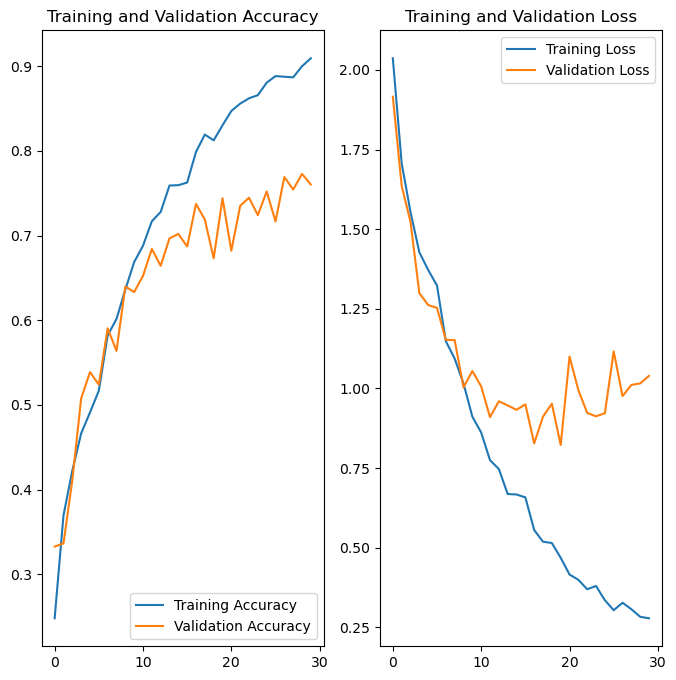

In [337]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There is a slight overfitting as training accuracy increased to 90 while validation accuracy is still at 76
If we reduce the epoch to 20 we defnitely see that class imabalance has helped in reducing the difference between training and validation accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


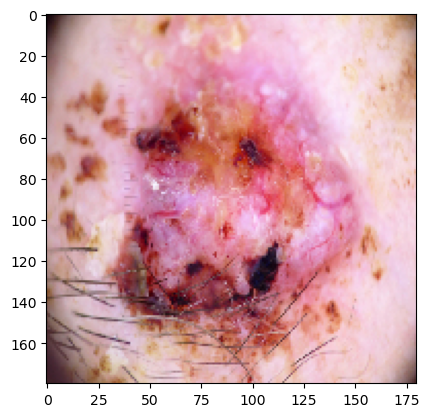

In [344]:
# Evaluating our model on one of the instances in the test set
from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[4], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)